# IA712 - Multimodal dialogue 

## TP LABAN - Multimodal systems

### Louis-Gabriel Pouillot - MSIA 2021-2022

Mai 2022


In [2]:
from tkinter import *
import PIL
from PIL import Image, ImageDraw
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import linear_model
from sklearn.metrics import r2_score
from collections import deque
from random import shuffle
from collections import Counter
import time


In [10]:
### constants

# data capture framework
sampling_frequency = 1.0    # sampling frequency of the mouse
canvas_size = (640, 480)    # size in pixels of the canvas for collecting mouse data

# analysis framework
weights = np.array([
    [0.5, 0.5],            # weights for the Space features
    [0.1, 0.9]             # weights for the Time features
])

enable_continuous_analysis = 0     # dont' touch, its value is set automatically by the canvas
buffer_size = 55               # size of the fixed time window used for the continuous analysis only
character_changed = 0           # it indicates if the next character of the sequence has to be played
characters= ['cook','kangaroo','airplane','woodman'] #the characters of the game
count_buffers = 0
count = -1
count_attempts = 0


### global variables and data structures

buffer = deque([], buffer_size)   # used for continuous analysis only
how_many = 0                      # used for continuous analysis only
results = list()                  # used for continuous analysis only
lastx, lasty = None, None
affiche = []

def initialize():
    global buffer, how_many, results
          
    for i in range(1, buffer_size):
        buffer.append((0,0))
    how_many = 0
    results = []
    return

def append(point):
    global buffer, how_many
    buffer.appendleft(point)
    how_many = how_many + 1
    return

def append_result(data):
    global results
    results.append(data) 
    return

def who_is_mimicked(results):
    #FILL HERE!
    x = Counter(results)
    who_is = max(x, key=x.get)
    return(who_is)
 

def start_analysis():
    global enable_continuous_analysis, character_changed, count, count_attempts, affiche
    delete_image()
    sequence_char = generate_characters_sequence()
    
    enable_continuous_analysis  = 1
    character_changed = 1
    count = -1
    
    count_attempts = 0
    affiche = []
    
    return

def generate_characters_sequence():
    global characters
    #FILL HERE!
    shuffle(characters)
    print("newly ordered characters", characters)
    return characters

### Laban analysis functions  

# Laban's Space
def get_distance(point1, point2):
    return np.linalg.norm(np.array(point2) - np.array(point1))

def path_length(points):
    length = 0
    for (i, j) in zip(points, points[1:]):
        length += get_distance(i, j)
    return length

def directness_index(points):
    #FILL HERE!
    p1 = points[0]
    pn= points[-1]
    d = get_distance(p1, pn)
    s = 0
    for i in range(len(points)-2):
        s += get_distance(points[i], points[i+1])
    if s == 0:
        s = 1
    DI = d / s
    return DI

def goodness_of_linear_fit(points):
    #FILL HERE!

    x = np.array([x for x, _ in points]).reshape((-1, 1))
    y = np.array([y for _, y in points])
    reg = linear_model.LinearRegression().fit(x, y)
    
    y_pred = reg.predict(x)
    
    r2 = r2_score(y, y_pred)
    return r2

def laban_space(points, weights, canvas_size=(640, 480), display=0):
    s1 = directness_index(points)
    s2 = goodness_of_linear_fit(points)
    score = weights[0] * s1 + weights[1] * s2
    if (display == 1):
        print("\n--- Laban's Space features ---")
        print("Directness index =", s1)
        print("Goodness of fit =", s2)
        print("Total Space score =", score)
    return score

# Laban's Time
def speed(points, fs=1.0):
    dt = 1.0 / fs
    sp = []
    for (i, j) in zip(points, points[1:]):
        sp.append(np.linalg.norm([(j[0] - i[0]) / dt, (j[1] - i[1]) / dt]))
    return sp

def average_normalized_kinetic_energy(points, fs=1.0):
    sp = speed(points, fs)
    squares = np.square(sp)
    max_square = np.amax(squares)
    return np.mean(np.divide(squares, max_square))


def impulsiveness(points, fs=1.0):
    #FILL HERE!
    
    speeds = speed(points, fs)
    smax = np.max(speeds)
    IMP = smax / len(speeds)
 
    #Since Imp belongs to [0, +∞), it needs to be normalized so that values in between 0 and 1 are mapped
    #onto [0, 0.5] and values in between 1 and +∞ are mapped onto (0.5, 1).
    def normalize_imp(x, mini=0, maxi=np.inf):
        return x / ( x + 1 )
    #     return 1/(1 + np.exp(-x))

    IMP =  normalize_imp(IMP)
    
    return IMP

def laban_time(points, weights, fs=1.0, display=0):
    t1 = average_normalized_kinetic_energy(points)
    t2 = impulsiveness(points)
    score = weights[0] * t1 + weights[1] * t2

    if (display == 1):
        print("\n--- Laban's Time features ---")
        print("Average normalized kinetic energy =", t1)
        print("Impulsiveness =", t2)
        print("Total Time score =", score)
    return score

# Laban's analysis
def laban_analysis(data, weights, canvas_size=(640, 480), fs=1.0, display=0):
    if len(data) != 0:
        s = laban_space(data, weights[0,:], canvas_size, display=0)
        t = laban_time(data, weights[1,:], sampling_frequency, display=0)
#         print("laban_analysis", s, " --- ", t)
        return s, t
    else:
        return -1, -1
    
def analyse_continuous_data(): #MODIFY THIS FUNCTION!
    # "affiche" gloabl var added
    global count_buffers, results, count, characters, character_changed, count_attempts, affiche
    s, t = laban_analysis(list(buffer), weights)
    if (s == -1 and t == -1):
        print("Warning: no data to analyze.")
        return
    r = which_character(s, t)
#     print("which_character", r)
    append_result(r)
    count_buffers = count_buffers +1
    
    if count_buffers == 5:
            
        char_mimicked = who_is_mimicked(results)
         
        #FILL HERE - COMPLEMENT
        print("Essai n° ", count_attempts+1, end='')
        print(" - who:", characters[count], "done:", char_mimicked, end='\n')
        if char_mimicked == characters[count]:
            count_attempts = 0
            character_changed = 1
            print("<< BINGO, tu es très bon. >>")
            affiche.append("x")
            delete_image()
        # ajout du nombre de tentative
        elif count_attempts >= 2:
            count_attempts = 0
            character_changed = 1
            print("<< Tu y arriveras la prochaine fois >>")
            affiche.append("_")
            delete_image()
        else:
            count_attempts +=1
            delete_image()
            cv.create_text(100,25,fill="darkblue",font="Times 20 bold",text=f"Essai n° {count_attempts+1}/3")
            cv.create_text(100,60,fill="darkblue",font="Times 20 bold",text=f'Résultats: {"".join(affiche)}')
            cv.create_text(500,25,fill="darkblue",font="Times 20 italic bold",text=characters[count])

        count_buffers = 0
        results = []
        buffer.clear()
#         print("END of the current attempt")
            
    return  

    
def which_character(s, t):
    if s < 0.5 and t < 0.45:
        r="cook"
    elif s > 0.45 and t > 0.45:
        r="airplane"
    elif s < 0.5 and t > 0.55:
        r="kangaroo"
    elif s >0.55 and t < 0.45:
        r="woodman"
    else:
        r="Try again, I do not understand who is mimicked!"
    return r 

def synthesis(ch): 
    #FILL HERE!
    print("!!!!!!!!!!!!!! SYNTHESISSSIS !!!!!!!!!!!!")
    cv.create_text(250,200,fill="darkblue",font="Times 20 italic bold",text=", ".join([x for x in ch]))
    cv.create_text(100,50,fill="darkblue",font="Times 20 bold",text=f'Résultats: {"".join(affiche)}')
#     root.destroy()
    return

### canvas and buttons handling functions

def create_widgets():
    deleteb = Button(cv, text = 'Delete', command = delete_image)
    deleteb.configure(width = 20)
    deleteb_window = cv.create_window(300, 450, anchor = CENTER, window=deleteb)
    
    startgameb=Button(cv, text = 'Start Game', command = start_analysis)
    startgameb.configure(width=20)
    startgameb_window = cv.create_window(100, 450, anchor = CENTER, window=startgameb)
    
    #FILL HERE! COMPLEMENT
    endb = Button(cv, text = 'End game', command = end_game)
    endb.configure(width = 20)
    endb_window = cv.create_window(500, 450, anchor = CENTER, window=endb)
    
    
    cv.bind('<1>', activate_paint)
    cv.pack(expand=YES, fill=BOTH)
    return

def activate_paint(e):
    global lastx, lasty
    cv.bind('<B1-Motion>', paint)
    lastx, lasty = e.x, e.y
    return

def paint(e):
    global lastx, lasty, count, count_attempts, character_changed
    x, y = e.x, e.y
    cv.create_line((lastx, lasty, x, y), width=1)
    draw.line((lastx, lasty, x, y), fill='black', width=1)
    lastx, lasty = x, y
    append((lastx, lasty)) 
    
    if character_changed == 1 and count <=3:
        count=count+1
        
        if count==4:
            synthesis(characters)
            return
        
        #FILL HERE - COMPLEMENT
        if count_attempts == 0:
            cv.create_text(100,25,fill="darkblue",font="Times 20 bold",text=f"Essai n° {count_attempts+1}/3")
            cv.create_text(100,60,fill="darkblue",font="Times 20 bold",text=f'Résultats: {"".join(affiche)}')
            print("<< Fais des mouvements >> ")
        
        cv.create_text(500,25,fill="darkblue",font="Times 20 italic bold",text=characters[count])
        print(f"<< {characters[count]} >>")

        character_changed = 0
        
        print("Number of character in the sequence:",count+1)
        
    if how_many >= buffer_size and enable_continuous_analysis and (how_many % buffer_size*0.5)==0 and count <= 3:
        analyse_continuous_data()
      
    return
    
    
def end_game():
    root.destroy()
    return

def delete_image():
    cv.delete("all")
    create_widgets()
    return


### main program

initialize()
root = Tk()
cv = Canvas(root, width=canvas_size[0], height=canvas_size[1], bg='white')
im = PIL.Image.new('RGB', canvas_size, 'white')
draw = ImageDraw.Draw(im)
create_widgets()
root.mainloop()


newly ordered characters ['kangaroo', 'airplane', 'woodman', 'cook']
<< Fais des mouvements >> 
<< kangaroo >>
Number of character in the sequence: 1
Essai n°  1 - who: kangaroo done: cook
Essai n°  2 - who: kangaroo done: cook
Essai n°  3 - who: kangaroo done: cook
<< Tu y arriveras la prochaine fois >>
<< Fais des mouvements >> 
<< airplane >>
Number of character in the sequence: 2
Essai n°  1 - who: airplane done: woodman
Essai n°  2 - who: airplane done: woodman
Essai n°  3 - who: airplane done: airplane
<< BINGO, tu es très bon. >>
<< Fais des mouvements >> 
<< woodman >>
Number of character in the sequence: 3
Essai n°  1 - who: woodman done: woodman
<< BINGO, tu es très bon. >>
<< Fais des mouvements >> 
<< cook >>
Number of character in the sequence: 4
Essai n°  1 - who: cook done: woodman
Essai n°  2 - who: cook done: woodman
Essai n°  3 - who: cook done: woodman
<< Tu y arriveras la prochaine fois >>
!!!!!!!!!!!!!! SYNTHESISSSIS !!!!!!!!!!!!
newly ordered characters ['airplane

### Sorties (logs)

Le programme affiche des sorties telle que ci-dessous et affiche le résultat des réussites (x) et échecs (_) comme affiché dans le screen shot (POC style).

<pre>
new ordered characters ['cook', 'airplane', 'woodman', 'kangaroo']
<< cook >>
Number of character in the sequence: 1
Essai n°  1 - who: cook done: Try again, I do not understand who is mimicked!
Essai n°  2 - who: cook done: cook
<< BINGO, tu es très bon. >>
<< airplane >>
Number of character in the sequence: 2
Essai n°  1 - who: airplane done: cook
Essai n°  2 - who: airplane done: woodman
Essai n°  3 - who: airplane done: woodman
<< Tu y arriveras la prochaine fois >>
<< woodman >>
Number of character in the sequence: 3
Essai n°  1 - who: woodman done: cook
Essai n°  2 - who: woodman done: woodman
<< BINGO, tu es très bon. >>
<< kangaroo >>
Number of character in the sequence: 4
Essai n°  1 - who: kangaroo done: cook
Essai n°  2 - who: kangaroo done: Try again, I do not understand who is mimicked!
Essai n°  3 - who: kangaroo done: Try again, I do not understand who is mimicked!
<< Tu y arriveras la prochaine fois >>
!!!!!!!!!!!!!! SYNTHESISSSIS !!!!!!!!!!!!
</pre>

### GUI


Affichage du 1er essai de la 4ème interaction (après 3 réussites et 1 échec)



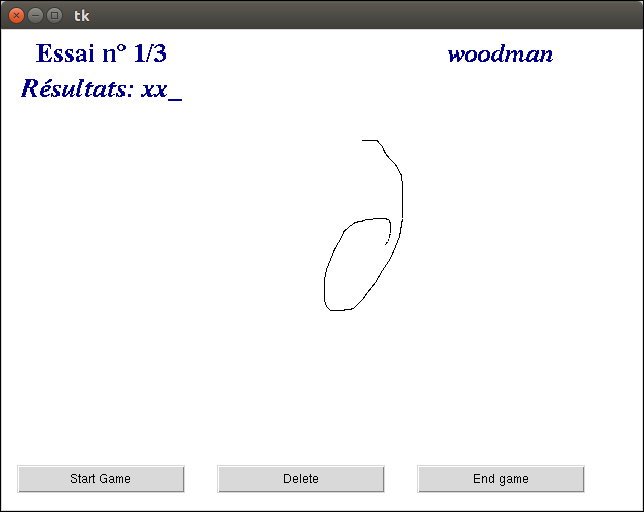

In [14]:
#Import library
from IPython.display import Image

print("\nAffichage du 1er essai de la 4ème interaction (après 3 réussites et 1 échec)\n")
Image(filename = "laban.png") 


Affichage de fin des interactions



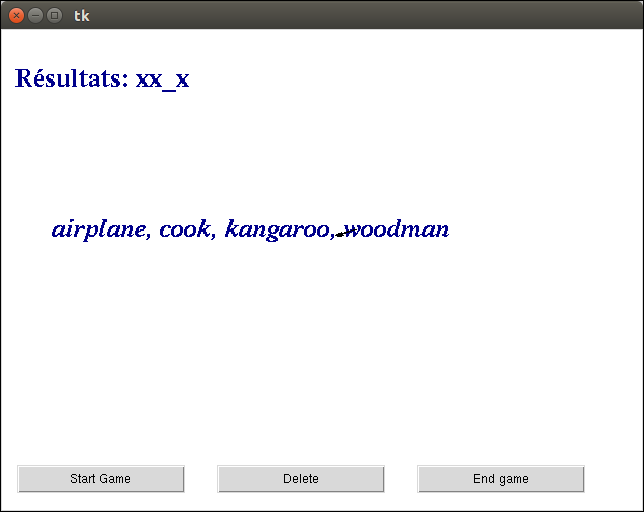

In [13]:
print("\nAffichage de fin des interactions\n")
Image(filename = "laban2.png")

### Question 8. 

> Consider the Interaction manager module of the W3C framework for multimodal interaction.

> Which turn taking strategy does this system implement? Briefly discuss pros and cons of this choice and identify possible directions for improving interaction with the system.


Les tours de parole entre le système et l'utilisateur sont organisés via des échanges par affichage à l'écran (ou dans les logs) pour les outputs et l'utilisation de la souris pour les inputs.

Le système est assez simple. L'utilisateur lance le programme en cliquant sur le bouton "Start Game" et un mot devrait lui être proposé à l'oral représentant un geste à produire. En l'absence de sortie sonore sur cette maquette, le mot est affiché à l'écran à la place. L'utilisateur devrait mimer des gestes afin qu'ils soient analysés par un système de détections et d'analyse de mouvements avec une caéra Kinect. Là encore c'est via l'écran que l'interaction est captée en bougeant la souris. Il y a 4 séquences détectables par le système.

L'association du geste avec la séquence est réalisé à traversl'analyses des trajectoires avec une Laban Movement Analysis (LMA).

La version finale proposée ici permet de réaliser 3 essais pour chacun des 4 mots à découvrir. J'ai ajouté des informations supplémentaires pour le feedback tel que l'affichage du nombre d'essais ainsi les résultats au fur et à mesure (une croix pour un bon résultat et un underscore '\_' pour un résulats non trouvé après 3 essais. 
Des messages sont affichés dans les logs entourés de chevrons. Ils seraient prononcés dans le meilleur des cas.

#### Pros:
* interface simple avec une logique qu'on devine 
* très bien pour un POC

#### Cons:
* dans sa version actuelle les instructions ne sont pas très claires
* tkinter n'est pas très souple pour le rendu graphique, on comprend que l' "interaction" manager décrit par le W3C dispose de fonctionnalités plus egonomiques de rendu
* il n'y a pas de transition entre les séquences d'input (si on maintient le bouton de la souris en pression, le dessin continue)
* pas de sorties son ni de captation vidéo

#### Améliorations ajoutées : 
* delete_image appelé entre chaque essai, 
* affichage des résultats
* affichage du numéro de l'essai en cours
* permettre d'interrompre le jeu à tout moment 


#### Améliorations identifiées :
* communiquer (ou proposer de communiquer) les instructions à l'utilisateur
* indiquer le nombre de mots à découvrir
* donner des indications sur l'exécution du geste/mouvement (vitesse/direction/ryhtme)
* ajouter une transition dans la réalisation des séquences (on écrit sur la transition suivante)

